# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [4]:
!pip install --upgrade pip

In [5]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [6]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import smdebug
import sagemaker
import boto3

## Dataset
The Dataset contains different breeds of Dogs

In [7]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [8]:
sagemaker_session = sagemaker.Session()
bucket = "jedsoloproject3"
role = sagemaker.get_execution_role()

### Uploading Dataset to S3 bucket

In [9]:
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket)
print("input spec (in this case, just an S3 path): {}".format(inputs))

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [10]:
data_channels = {
                  "train" : f"s3://{bucket}/data/train/",
                  "valid" : f"s3://{bucket}/data/valid/",
                  "test" : f"s3://{bucket}/data/test/"
}

In [11]:
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [12]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "test Loss", "Regex": "Test Loss: ([0-9\\.]+)"}]

In [13]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [11]:
# TODO: Fit your HP Tuner
tuner.fit(data_channels, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................................................................................................................................................................................!


In [12]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-03-04 15:52:07 Starting - Found matching resource for reuse
2023-03-04 15:52:07 Downloading - Downloading input data
2023-03-04 15:52:07 Training - Training image download completed. Training in progress.
2023-03-04 15:52:07 Uploading - Uploading generated training model
2023-03-04 15:52:07 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"test Loss"',
 'batch-size': '"64"',
 'lr': '0.015563923350342495',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-04-15-34-11-813"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-516021449795/pytorch-training-2023-03-04-15-34-11-813/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [14]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

In [15]:
rules = [
        Rule.sagemaker(rule_configs.loss_not_decreasing()),
        ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
        ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
        Rule.sagemaker(rule_configs.vanishing_gradient()),
        Rule.sagemaker(rule_configs.overfit()),
        Rule.sagemaker(rule_configs.overtraining()),
        Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    s3_output_path=f"s3://{bucket}/output/",
    collection_configs=[
        CollectionConfig(
            name="CrossEntropyLoss_output",
            parameters={
                "include_regex": "CrossEntropyLoss_output.*",
                "train.save_interval": "100",
                "eval.save_interval": "10",
                "predict.save_interval": "10"}
        )]
)

In [14]:
# TODO: Create and fit an estimator
hyperparameters = {
    "batch-size": 64,
    "lr": 0.001,
    "epochs": 5,
}

estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

estimator.fit(data_channels, wait=True)

2023-03-22 09:18:21 Starting - Starting the training job...
2023-03-22 09:18:48 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2023-03-22 09:20:12 Downloading - Downloading input data......
2023-03-22 09:21:13 Training - Downloading the training image..................
2023-03-22 09:24:15 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-22 09:24:38,040 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-22 09:24:38,071 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-22 09:24:38,074 sagemaker_pytorch_container.training INFO     Invoking user trainin

In [15]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-03-22 09:36:46.452 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:45 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-03-22 09:36:46.490 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:45 INFO s3_trial.py:42] Loading trial debug-output at path s3://jedsoloproject3/output/pytorch-training-2023-03-22-09-18-21-034/debug-output


In [16]:
trial.tensor_names()

[2023-03-22 09:36:48.840 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:45 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-22 09:36:49.858 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:45 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [17]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


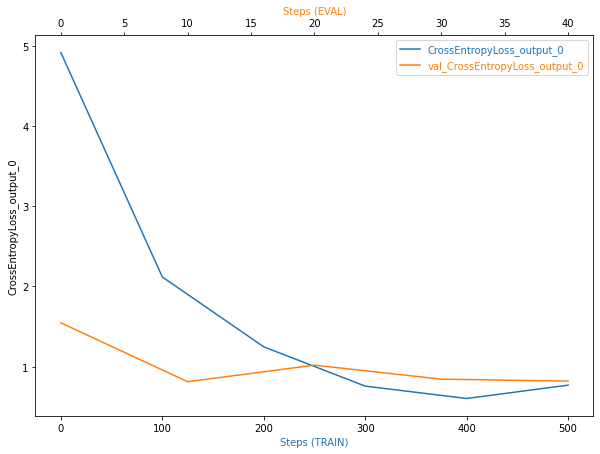

In [19]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [20]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-516021449795/pytorch-training-2023-03-22-09-18-21-034/rule-output


In [21]:
! aws s3 ls {rule_output_path} --recursive

2023-03-22 09:33:35     435330 pytorch-training-2023-03-22-09-18-21-034/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-22 09:33:34     293905 pytorch-training-2023-03-22-09-18-21-034/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-22 09:33:30        549 pytorch-training-2023-03-22-09-18-21-034/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-22 09:33:30      33741 pytorch-training-2023-03-22-09-18-21-034/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-22 09:33:30       1949 pytorch-training-2023-03-22-09-18-21-034/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-22 09:33:30        130 pytorch-training-2023-03-22-09-18-21-034/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-03-22 09:33:30        829 pytorch-training-2023-03-22-09-18-21-034/rule-output/ProfilerReport/profiler-output/profiler-re

In [22]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-516021449795/pytorch-training-2023-03-22-09-18-21-034/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-516021449795/pytorch-training-2023-03-22-09-18-21-034/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-516021449795/pytorch-training-2023-03-22-09-18-21-034/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-516021449795/pytorch-training-2023-03-22-09-18-21-034/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-516021449795/pytorch-training-2023-03-22-09-18-

In [23]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [24]:
# import IPython

# IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [16]:
from sagemaker.pytorch import PyTorchModel

#### Reloading trained model

In [17]:

model_data = "s3://sagemaker-us-east-1-516021449795/pytorch-training-2023-03-22-09-18-21-034/output/model.tar.gz"

estimator = PyTorchModel(model_data=model_data, 
                         framework_version='1.8',
                         entry_point="train_model.py",
                         role=role,
                         py_version='py36',
                        sagemaker_session=sagemaker_session)

In [18]:
# TODO: Deploy your model to an endpoint

predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") # TODO: Add your deployment configuration like instance type and number of instances

-----------!

In [26]:
from train_model import create_data_loaders

In [27]:
test_loader = create_data_loaders("./dogImages/test/", 1)

In [28]:
for image, target in test_loader:
    break

In [29]:
image.shape

torch.Size([1, 3, 224, 224])

In [30]:
# TODO: Run an prediction on the endpoint
response = predictor.predict(image)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2023-03-22-10-10-26-243 in account 516021449795 for more information.

In [19]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()